In [2]:
from matplotlib import pyplot as plt

import numpy as np
rng = np.random.Generator(np.random.PCG64(1234))

def v(rng, sz=4, vsigma=0.001):
    return rng.normal(0,vsigma,sz)

def w(rng, sz=4, vsigma=0.001):
    return rng.normal(0,vsigma,sz)


def u(t):
    if t<0:
        raise ValueError(f'{t} is out of range')
    if t<0.5:
        return 0
    if t<1.5:
        return 0.01
    if t<2.5:
        return 0
    if t<3.5:
        return -0.01
    if t<5:
        return 0
    raise ValueError(f'{t} is out of range')
        

In [209]:
'''
    dx/dt = Ax + Bu
        y = Cx

        x : (n_state, 1)
        B : (n_state, 1)
        y : (n_observer,1)
        C : (n_observer, n_state)
'''

def forward_pass(xk, tk, dt_out):
    m1=1e-6;         # Mass/inertia m1                     
    d1=4e-6;         # Damping that connects m1 to ground  
    k1=2e-4;         # Spring that connect m1 to ground
    m2=1e-6;         # Mass/inertia m2                     
    d2=1e-6;         # Damping that connects m2 to ground 
    k2=1e-4;         # Spring that connects m1 and m2      
    
    Ac = np.array([[0, 1, 0, 0,],
                   [-(k1+k2)/m1, -d1/m1, k2/m1, 0],
                   [0, 0, 0, 1],
                   [k2/m2, 0, -k2/m2, -d2/m2]])
    
    Bc = np.array([[0, 1/m1, 0, 0]]).transpose();
    
    
    # Remove instabilities
    dt_sim = 0.001
    A = (Ac*dt_sim + np.eye(len(Ac))) 
    B = Bc*dt_sim
    xk_forward = xk
    for i in range(int(dt_out/dt_sim)):
        xk_forward = np.matmul(A, xk_forward) + B*u(tk+i*dt_sim)
    
    return (Ac*dt_out + np.eye(len(Ac))), xk_forward

In [169]:


# % create noise
# lambda = 2; % general noise size level
# H = lambda * [[eye(n_states) [0.5 0 0.5 0]'] ; [[0.5 0 0.5 0] 5*eye(n_outputs)]];
# noise = H*randn(n_states + n_outputs,T);
# w = noise(1:n_states,:);
# v = noise(n_states + n_outputs,:);

In [206]:
noise[4,:].shape

(500,)

In [224]:
x1in = 50
v1in = 0
x2in = 50
v2in = 0

xk = np.array([[x1in, v1in, x2in, v2in]]).transpose()
tfin = 5
tin = 0
dt = 1/20
tar = np.arange(tin, tfin, dt)

n_states = 4    # (y1, v1, y2, v2)
n_output = 1

xkar = np.zeros((len(tar), n_states))
xkar_nf = np.zeros_like(xkar)
xkar_hat = np.zeros_like(xkar)
xkar_nf[0,:] = xk.flatten()

ykar = np.zeros((len(tar), n_output))
ykar_nf = np.zeros_like(ykar)
C = np.array([[1,0,0,0]]);
ykar_nf[0,:] = np.matmul(C, xk)

# Generate noise
l = 2 # general noise size level
H = np.array([[2,0,0,0,1],
              [0,2,0,0,0],
              [0,0,2,0,1],
              [0,0,0,2,0],
              [1,0,1,0,10]])

noise = np.matmul(H, rng.normal(size=(n_states+n_output, len(tar))))
wkar = noise[:n_states, :].T
vkar = noise[n_states+n_output-1,:].reshape(1,len(tar)).T

# # Process error
# wkar = rng.normal(0,scale=2, size=xkar.shape)
# # Observation error
# vkar = rng.normal(0,scale=2, size=ykar.shape)

for k in range(len(tar)-1):
    wk = wkar[k:(k+1),:].T
    vk = vkar[k:(k+1),:].T

    xk = xkar[k:(k+1),:].T
    xk_nf = xkar_nf[k:(k+1),:].T
    tk = tar[k]

    # Noise free state
    A, xk_forward_nf = forward_pass(xk_nf, tk, dt)
    xkar_nf[k+1,:] = xk_forward_nf.flatten()

    # Added noise with N(0,2)
    A, xk_forward = forward_pass(xk, tk, dt)
    xkar[k+1,:] = xk_forward.flatten() + wk.flatten()

    ykar_nf[k+1,:] = np.matmul(C, xk_forward_nf)
    ykar[k+1,:] = np.matmul(C, xk_forward)

    wv = np.append(wk, vk, axis=0)
    WV = np.matmul(wv, wv.T)
    
    W = WV[:n_states,:n_states]
    V = WV[n_states:(n_states+1), n_states:(n_states+1)]
    S = WV[:n_states, n_states:(n_states+1)]
    
    P = ct.dare(A.T, C.T, W, V, S)[0]
    L = np.linalg.pinv(np.matmul(np.matmul(C,P),C.T)+V)

    xkar_hat[k+1, :] = (xk_forward_nf + np.matmul(L, (np.matmul(C, xkar_hat[k,:].reshape(xk.shape)) - np.matmul(C, xk_nf)))).flatten();

(-100.0, 100.0)

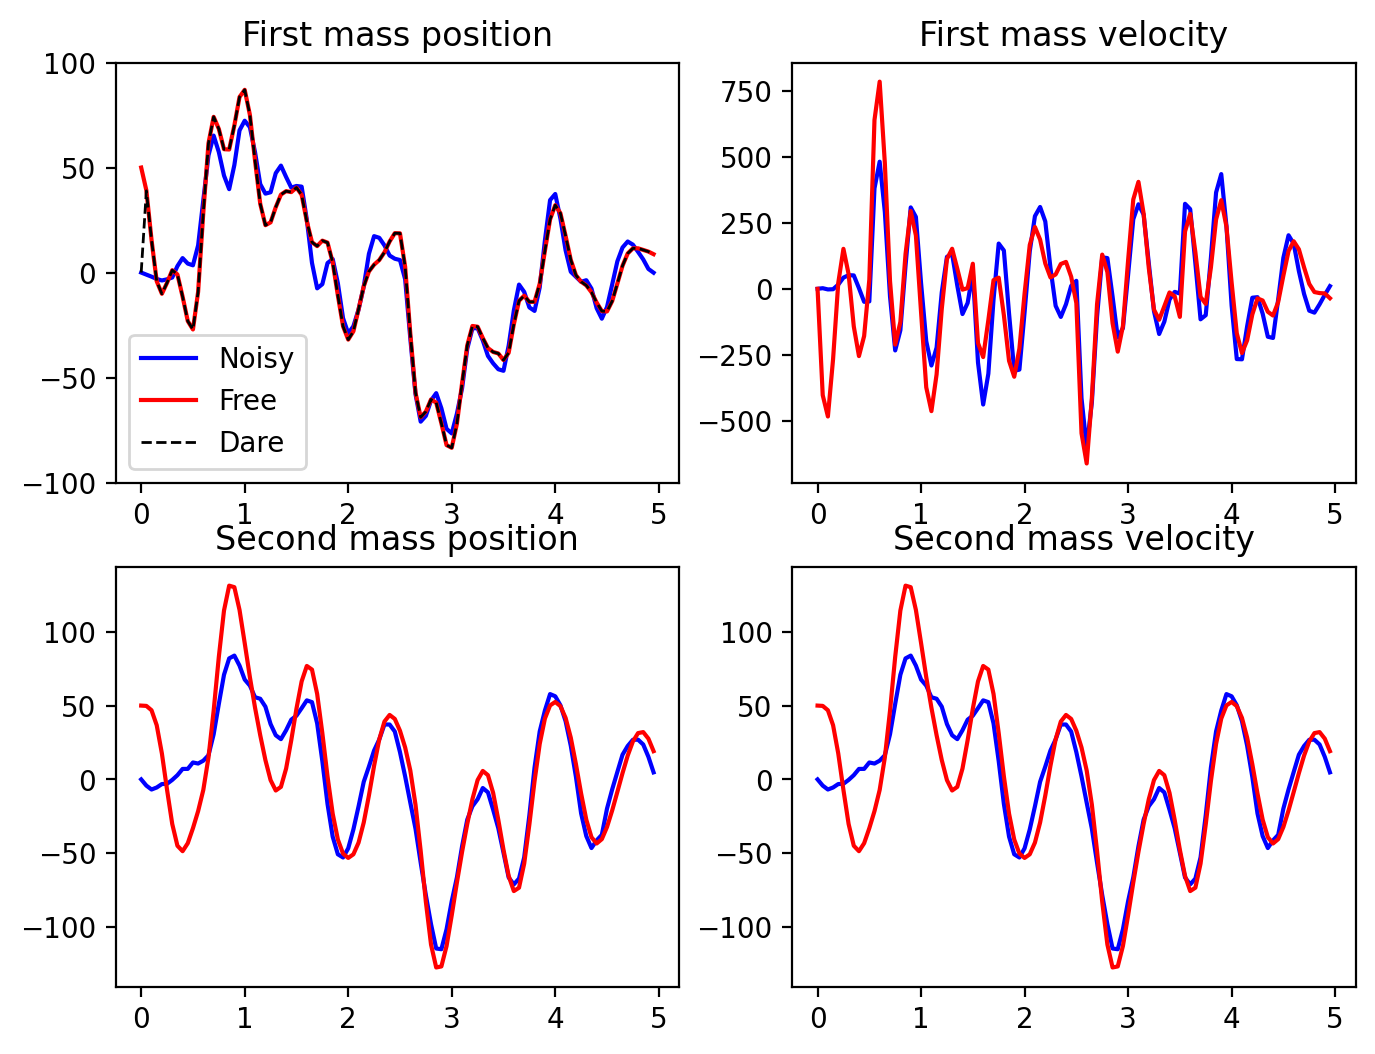

In [225]:
fig, axes = plt.subplots(2,2, figsize=(8,6), dpi=200)

axes[0,0].plot(tar, xkar[:,0], 'b-', label='Noisy')
axes[0,0].plot(tar, xkar_nf[:,0], 'r-', label='Free')
axes[0,0].plot(tar, xkar_hat[:,0], 'k--', lw=1, label='Dare')
axes[0,0].set_title('First mass position')

axes[0,1].plot(tar, xkar[:,1], 'b-', label='Noisy')
axes[0,1].plot(tar, xkar_nf[:,1], 'r-', label='Free')
# axes[0,1].plot(tar, xkar_hat[:,1], 'k--', lw=1, label='Dare')
axes[0,1].set_title('First mass velocity')

axes[1,0].plot(tar, xkar[:,2], 'b-', label='Noisy')
axes[1,0].plot(tar, xkar_nf[:,2], 'r-', label='Free')
# axes[1,0].plot(tar, xkar_hat[:,2], 'k--', lw=1, label='Dare')
axes[1,0].set_title('Second mass position')

axes[1,1].plot(tar, xkar[:,2], 'b-', label='Noisy')
axes[1,1].plot(tar, xkar_nf[:,2], 'r-', label='Free')
# axes[1,1].plot(tar, xkar_hat[:,2], 'k--', lw=1, label='Dare')
axes[1,1].set_title('Second mass velocity')

axes[0,0].legend()

axes[0,0].set_ylim(-100,100)

(array([[ 2.,  0.,  9.,  8., 18., 14., 21., 20.,  6.,  2.],
        [ 1.,  2.,  8., 13., 20., 21., 20.,  7.,  6.,  2.],
        [ 1.,  2.,  8., 13., 14., 24., 21.,  9.,  4.,  4.],
        [ 0.,  0.,  3.,  7., 28., 33., 17.,  5.,  6.,  1.]]),
 array([-6.42387351, -5.23615518, -4.04843686, -2.86071854, -1.67300021,
        -0.48528189,  0.70243643,  1.89015476,  3.07787308,  4.2655914 ,
         5.45330973]),
 <a list of 4 BarContainer objects>)

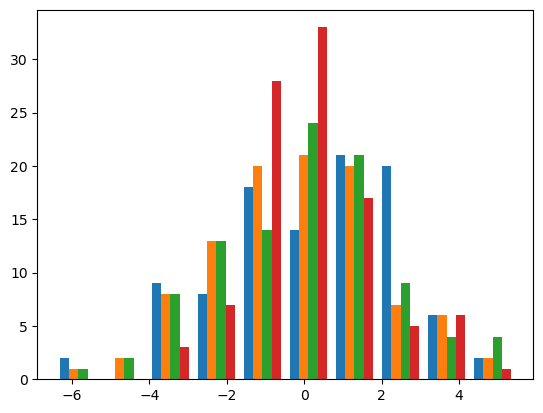

In [214]:
plt.hist(wkar)

array([[6.63139318]])

In [3]:
x1in = 1
v1in = 0
x2in = 2.5
v2in = 0

xk = np.array([[x1in],
               [v1in],
               [x2in],
               [v2in]])


tfin = 100
tin = 0
tar = np.arange(tin, tfin, dt)

xkar = np.zeros((len(tar), 4))
xkar[0,:] = xk.flatten()

xkarv = np.zeros((len(tar), 4))
xkarv[0,:] = xk.flatten() + v(rng)

In [4]:
for k in range(len(tar)-1):
    xkar[k+1,:] = (np.matmul(A, xkar[k:(k+1), :].T) + b).flatten()
    xkarv[k+1,:] = (np.matmul(A, xkarv[k:(k+1), :].T) + b).flatten() + v(rng)

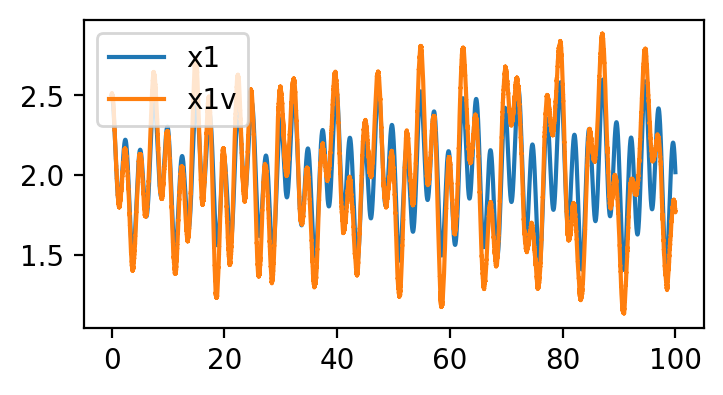

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

ax.plot(tar, xkar[:,2], label='x1')
ax.plot(tar, xkarv[:,2], label='x1v')

ax.legend()